<a href="https://colab.research.google.com/github/Jhatton2/customerSales/blob/main/M7_Exercise_Retail_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get your data from Canvas or find it here
#https://anindya-saha.github.io/blog/data-science-with-spark/retail-database-analysis-python/retail-database-analysis-python.html
# For example, https://github.com/anindya-saha/Data-Science-with-Spark/tree/master/retail-db-advanced-sql-analysis/data e.g. https://raw.githubusercontent.com/anindya-saha/Data-Science-with-Spark/master/retail-db-advanced-sql-analysis/data/customers.cs

# **`M7 - Part III of III`** **`->`** **`Apache Spark`**

## Exercise

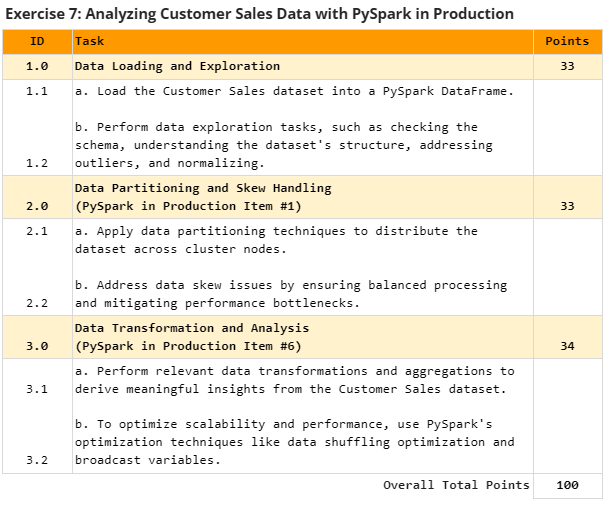

## Data Loading.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import (
    udf, col, when, to_date, sum as Fsum, avg, count, format_string,
    isnan, lit, date_sub
)
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import (
    LogisticRegression, NaiveBayes, DecisionTreeClassifier,
    RandomForestClassifier, LinearSVC
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import format_string

# Initialize SparkSession using getOrCreate()
spark = SparkSession.builder.appName("retail-database-analysis-python").getOrCreate()

# Define file paths
CUSTOMERS_DATA = 'data/customers.csv'
DEPARTMENTS_DATA = 'data/departments.csv'
CATEGORIES_DATA = 'data/categories.csv'
PRODUCTS_DATA = 'data/products.csv'
ORDERS_DATA = 'data/orders.csv'
ORDER_ITEMS_DATA = 'data/order_items.csv'

# Define schemas
customers_schema = StructType([
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('customer_fname', StringType(), nullable=True),
    StructField('customer_lname', StringType(), nullable=True),
    StructField('customer_email', StringType(), nullable=True),
    StructField('customer_password', StringType(), nullable=True),
    StructField('customer_street', StringType(), nullable=True),
    StructField('customer_city', StringType(), nullable=True),
    StructField('customer_state', StringType(), nullable=True),
    StructField('customer_zipcode', StringType(), nullable=True)
])

departments_schema = StructType([
    StructField('department_id', IntegerType(), nullable=True),
    StructField('department_name', StringType(), nullable=True)
])

categories_schema = StructType([
    StructField('category_id', IntegerType(), nullable=True),
    StructField('category_department_id', IntegerType(), nullable=True),
    StructField('category_name', StringType(), nullable=True)
])

products_schema = StructType([
    StructField('product_id', IntegerType(), nullable=True),
    StructField('product_category_id', IntegerType(), nullable=True),
    StructField('product_name', StringType(), nullable=True),
    StructField('product_description', StringType(), nullable=True),
    StructField('product_price', FloatType(), nullable=True),
    StructField('product_image', StringType(), nullable=True)
])

orders_schema = StructType([
    StructField('order_id', IntegerType(), nullable=True),
    StructField('order_date', StringType(), nullable=True),
    StructField('order_customer_id', IntegerType(), nullable=True),
    StructField('order_status', StringType(), nullable=True)
])

order_items_schema = StructType([
    StructField('order_item_id', IntegerType(), nullable=True),
    StructField('order_item_order_id', IntegerType(), nullable=True),
    StructField('order_item_product_id', IntegerType(), nullable=True),
    StructField('order_item_quantity', IntegerType(), nullable=True),
    StructField('order_item_subtotal', FloatType(), nullable=True),
    StructField('order_item_product_price', FloatType(), nullable=True)
])

# Load data
customers_df = spark.read.csv(path=CUSTOMERS_DATA, schema=customers_schema, header=False)
departments_df = spark.read.csv(path=DEPARTMENTS_DATA, schema=departments_schema, header=False)
categories_df = spark.read.csv(path=CATEGORIES_DATA, schema=categories_schema, header=False)
products_df = spark.read.csv(path=PRODUCTS_DATA, schema=products_schema, header=False)
orders_df = spark.read.csv(path=ORDERS_DATA, schema=orders_schema, header=False)
order_items_df = spark.read.csv(path=ORDER_ITEMS_DATA, schema=order_items_schema, header=False)

print("data load completed successfully!")


data load completed successfully!


In [38]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, to_date

# Convert 'order_date' to DateType
orders_df = orders_df.withColumn('order_date', to_date(col('order_date')))

# Join DataFrames
orders_order_items_df = orders_df.join(
    order_items_df,
    orders_df.order_id == order_items_df.order_item_order_id,
    'inner'
)

customer_sales_df = orders_order_items_df.join(
    customers_df,
    orders_df.order_customer_id == customers_df.customer_id,
    'inner'
)

customer_sales_df = customer_sales_df.join(
    products_df,
    orders_order_items_df.order_item_product_id == products_df.product_id,
    'left'
)

customer_sales_df = customer_sales_df.join(
    categories_df,
    products_df.product_category_id == categories_df.category_id,
    'left'
)

customer_sales_df = customer_sales_df.join(
    departments_df,
    categories_df.category_department_id == departments_df.department_id,
    'left'
)

# Select desired columns
final_columns = [
    'customer_id', 'customer_fname', 'customer_lname', 'customer_email',
    'order_id', 'order_date', 'order_status',
    'order_item_id', 'order_item_product_id', 'order_item_quantity',
    'order_item_subtotal', 'order_item_product_price',
    'product_name', 'product_price',
    'category_name',
    'department_name'
]

customer_sales_df = customer_sales_df.select(*final_columns)

# Save the DataFrame to CSV
output_path = 'customer_sales_output'

customer_sales_df.coalesce(1).write.csv(
    path=output_path,
    mode='overwrite',
    header=True
)

# Handle the output files to create a single 'customer_sales.csv' file
import os
import shutil

output_dir = 'customer_sales_output'
output_file = 'customer_sales.csv'

# Get the part file
part_file = ''
for filename in os.listdir(output_dir):
    if filename.startswith('part-') and filename.endswith('.csv'):
        part_file = os.path.join(output_dir, filename)
        break

if part_file:
    # Move and rename the part file to 'customer_sales.csv'
    shutil.move(part_file, output_file)
    # Remove the output directory
    shutil.rmtree(output_dir)
    print(f"Combined data saved to '{output_file}'.")
else:
    print("Part file not found. Please check the output directory.")


Combined data saved to 'customer_sales.csv'.


In [4]:

#show data schemes
customers_df.createOrReplaceTempView("customers")
customers_df.select([col(choice) for choice in np.random.choice(customers_df.columns, size=5, replace=False)]).show(5)

departments_df.createOrReplaceTempView("departments")
departments_df.show(5)

categories_df.createOrReplaceTempView("categories")
categories_df.show(5)

products_df.createOrReplaceTempView("products")
products_df.show(5)

orders_df.createOrReplaceTempView("orders")
orders_df.show(5)

order_items_df.createOrReplaceTempView("order_items")
order_items_df.show(5)

print("Customers DataFrame Columns:")
print(customers_df.columns)
customers_df.show(5)

# Data Preparation
orders_df = orders_df.withColumn('order_date', to_date(col('order_date')))
orders_order_items_df = orders_df.join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
customer_orders_df = orders_order_items_df.join(customers_df, orders_df.order_customer_id == customers_df.customer_id)

# Feature Engineering
customer_features_df = customer_orders_df.groupBy('customer_id').agg(
    Fsum('order_item_subtotal').alias('total_spent'),
    avg('order_item_subtotal').alias('avg_order_value'),
    count('order_id').alias('total_orders'),
    Fsum('order_item_quantity').alias('total_quantity'),
    Fsum(when(col('order_status') == 'CANCELED', 1).otherwise(0)).alias('num_cancellations'),
    Fsum(when(col('order_status') == 'RETURNED', 1).otherwise(0)).alias('num_returns')
)

# Format 'total_spent' and 'avg_order_value' to 2 decimal places using format_string
customer_features_df = customer_features_df.withColumn(
    'total_spent_formatted',
    format_string('%.2f', col('total_spent'))
)

customer_features_df = customer_features_df.withColumn(
    'avg_order_value_formatted',
    format_string('%.2f', col('avg_order_value'))
)

# Data Exploration
# Missing Value Analysis
def missing_values(df):
    missing_df = df.select([Fsum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    return missing_df

missing_values(customer_features_df).show()

# Statistical Summary
numerical_cols = ['total_spent', 'avg_order_value', 'total_orders', 'total_quantity', 'num_cancellations', 'num_returns']
customer_features_df.select(numerical_cols).describe().show()

# Outlier Detection and Handling
def cap_outliers(df, cols):
    for col_name in cols:
        quantiles = df.approxQuantile(col_name, [0.01, 0.99], 0.0)
        lower_cap = quantiles[0]
        upper_cap = quantiles[1]
        df = df.withColumn(col_name, when(col(col_name) < lower_cap, lower_cap)
                                     .when(col(col_name) > upper_cap, upper_cap)
                                     .otherwise(col(col_name)))
    return df

customer_features_df = cap_outliers(customer_features_df, numerical_cols)




+--------------+--------------+--------------+--------------+--------------------+
|customer_fname|customer_lname|customer_email|customer_state|     customer_street|
+--------------+--------------+--------------+--------------+--------------------+
|       Richard|     Hernandez|     XXXXXXXXX|            TX|  6303 Heather Plaza|
|          Mary|       Barrett|     XXXXXXXXX|            CO|9526 Noble Embers...|
|           Ann|         Smith|     XXXXXXXXX|            PR|3422 Blue Pioneer...|
|          Mary|         Jones|     XXXXXXXXX|            CA|  8324 Little Common|
|        Robert|        Hudson|     XXXXXXXXX|            PR|10 Crystal River ...|
+--------------+--------------+--------------+--------------+--------------------+
only showing top 5 rows

+-------------+---------------+
|department_id|department_name|
+-------------+---------------+
|            2|        Fitness|
|            3|       Footwear|
|            4|        Apparel|
|            5|           Golf|
|   

In [5]:
# Data Normalization
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features_raw')
customer_features_df = assembler.transform(customer_features_df)

scaler = StandardScaler(inputCol='features_raw', outputCol='features', withMean=True, withStd=True)
scalerModel = scaler.fit(customer_features_df)
customer_features_df = scalerModel.transform(customer_features_df)

# Label Definition
median_total_spent = customer_features_df.approxQuantile("total_spent", [0.5], 0.0)[0]
print(f"Median Total Spent: {median_total_spent:.2f}")

customer_features_df = customer_features_df.withColumn('label', when(col('total_spent') >= median_total_spent, 1).otherwise(0))

# Format median_total_spent
median_total_spent_formatted = f"{median_total_spent:.2f}"
print(f"Median Total Spent (Formatted): {median_total_spent_formatted}")

# Train-Test Split
(trainingData, testData) = customer_features_df.randomSplit([0.7, 0.3], seed=42)


Median Total Spent: 2599.59
Median Total Spent (Formatted): 2599.59


In [6]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20)
lr_model = lr.fit(trainingData)
lr_predictions = lr_model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc:.4f}")

# Format 'total_spent' and 'avg_order_value' in predictions
lr_predictions = lr_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.4f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.4f', col('avg_order_value'))
)

# Show sample predictions with formatted outputs
lr_predictions.select(
    'customer_id', 'label', 'prediction', 'probability',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)


Logistic Regression AUC: 0.9999
+-----------+-----+----------+-----------------------------------------+---------------------+-------------------------+
|customer_id|label|prediction|probability                              |total_spent_formatted|avg_order_value_formatted|
+-----------+-----+----------+-----------------------------------------+---------------------+-------------------------+
|3          |1    |1.0       |[9.008216029723527E-37,1.0]              |3537.6801            |196.5378                 |
|7          |1    |1.0       |[4.9734624371642815E-109,1.0]            |5569.4801            |253.1582                 |
|9          |1    |1.0       |[5.161231745601277E-24,1.0]              |3229.6801            |230.6914                 |
|10         |0    |0.0       |[1.0,0.0]                                |1264.7900            |158.0988                 |
|14         |0    |0.0       |[0.9999999791279435,2.087205652756552E-8]|2414.7200            |185.7477                 |


In [7]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20)
lr_model = lr.fit(trainingData)
lr_predictions = lr_model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc:.4f}")

# Format 'total_spent' and 'avg_order_value' in predictions
lr_predictions = lr_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.4f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.4f', col('avg_order_value'))
)

# Show sample predictions with formatted outputs
lr_predictions.select(
    'customer_id', 'label', 'prediction', 'probability',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)


Logistic Regression AUC: 0.9999
+-----------+-----+----------+-----------------------------------------+---------------------+-------------------------+
|customer_id|label|prediction|probability                              |total_spent_formatted|avg_order_value_formatted|
+-----------+-----+----------+-----------------------------------------+---------------------+-------------------------+
|3          |1    |1.0       |[9.008216029723527E-37,1.0]              |3537.6801            |196.5378                 |
|7          |1    |1.0       |[4.9734624371642815E-109,1.0]            |5569.4801            |253.1582                 |
|9          |1    |1.0       |[5.161231745601277E-24,1.0]              |3229.6801            |230.6914                 |
|10         |0    |0.0       |[1.0,0.0]                                |1264.7900            |158.0988                 |
|14         |0    |0.0       |[0.9999999791279435,2.087205652756552E-8]|2414.7200            |185.7477                 |


In [8]:
# Naive Bayes
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.classification import NaiveBayes

def shift_features_vector(features):
    min_value = float(min(features))
    shifted = [float(x - min_value) for x in features]
    return Vectors.dense(shifted)

shift_vector_udf = udf(shift_features_vector, VectorUDT())

trainingData = trainingData.withColumn('features_nb', shift_vector_udf(col('features')))
testData = testData.withColumn('features_nb', shift_vector_udf(col('features')))

nb = NaiveBayes(featuresCol='features_nb', labelCol='label', smoothing=1.0, modelType='multinomial')
nb_model = nb.fit(trainingData)
nb_predictions = nb_model.transform(testData)
nb_auc = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes AUC: {nb_auc:.4f}")

# Format 'total_spent' and 'avg_order_value' in predictions
nb_predictions = nb_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.4f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.4f', col('avg_order_value'))
)

# Show sample predictions with formatted outputs
nb_predictions.select(
    'customer_id', 'label', 'prediction', 'probability',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)

# Model Comparison
print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Naive Bayes AUC: {nb_auc:.4f}")


Naive Bayes AUC: 0.5181
+-----------+-----+----------+----------------------------------------+---------------------+-------------------------+
|customer_id|label|prediction|probability                             |total_spent_formatted|avg_order_value_formatted|
+-----------+-----+----------+----------------------------------------+---------------------+-------------------------+
|3          |1    |1.0       |[0.14839061363145545,0.8516093863685446]|3537.6801            |196.5378                 |
|7          |1    |1.0       |[0.023207208914061073,0.976792791085939]|5569.4801            |253.1582                 |
|9          |1    |1.0       |[0.4969472468561149,0.5030527531438851] |3229.6801            |230.6914                 |
|10         |0    |0.0       |[0.7198210343891099,0.28017896561088995]|1264.7900            |158.0988                 |
|14         |0    |0.0       |[0.5298331808379532,0.4701668191620469] |2414.7200            |185.7477                 |
+-----------+---

In [9]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import VectorAssembler, StandardScaler


# Feature Vectorization

# List of feature columns
feature_columns = ['avg_order_value', 'total_orders', 'total_quantity', 'num_cancellations', 'num_returns']

# Drop 'features_raw' if it exists
if 'features_raw' in customer_features_df.columns:
    customer_features_df = customer_features_df.drop('features_raw')

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features_raw')
customer_features_df = assembler.transform(customer_features_df)

# Drop 'features' if it exists
if 'features' in customer_features_df.columns:
    customer_features_df = customer_features_df.drop('features')


In [10]:
# Feature scaling
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(customer_features_df)
customer_features_df = scalerModel.transform(customer_features_df)

# Split the data into training and test sets
(trainingData, testData) = customer_features_df.randomSplit([0.7, 0.3], seed=42)

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)

# Train the model
dt_model = dt.fit(trainingData)

# Make predictions on the test data
dt_predictions = dt_model.transform(testData)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# Evaluate the model
dt_auc = evaluator.evaluate(dt_predictions)
print(f"Decision Tree AUC: {dt_auc:.2f}")


Decision Tree AUC: 1.00


In [11]:
from pyspark.sql.functions import format_string

# Format 'total_spent' and 'avg_order_value' in predictions
dt_predictions = dt_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.2f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.2f', col('avg_order_value'))
)

# Show sample predictions with formatted outputs
dt_predictions.select(
    'customer_id', 'label', 'prediction', 'probability',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)


+-----------+-----+----------+------------------------------------------+---------------------+-------------------------+
|customer_id|label|prediction|probability                               |total_spent_formatted|avg_order_value_formatted|
+-----------+-----+----------+------------------------------------------+---------------------+-------------------------+
|3          |1    |1.0       |[0.0,1.0]                                 |3537.68              |196.54                   |
|7          |1    |1.0       |[0.0,1.0]                                 |5569.48              |253.16                   |
|9          |1    |1.0       |[0.0,1.0]                                 |3229.68              |230.69                   |
|10         |0    |0.0       |[0.9989539748953975,0.0010460251046025104]|1264.79              |158.10                   |
|14         |0    |0.0       |[0.9907063197026023,0.00929368029739777]  |2414.72              |185.75                   |
+-----------+-----+-----

In [12]:
# Get feature importances
import pandas as pd

feature_importances = dt_model.featureImportances.toArray()
features_list = feature_columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Collect a sample of the data to the driver
sample_data = customer_features_df.select('features', 'label').sample(False, 0.1, seed=42).collect()


Feature Importances:
             Feature  Importance
1       total_orders    0.833752
0    avg_order_value    0.166248
2     total_quantity    0.000000
3  num_cancellations    0.000000
4        num_returns    0.000000


In [13]:
#KNN
import pandas as pd
from pyspark.ml.linalg import Vectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Convert Spark DataFrame to pandas DataFrame
features_list = [row['features'] for row in sample_data]
labels_list = [row['label'] for row in sample_data]

# Convert features to numpy arrays
features_array = np.array([np.array(features) for features in features_list])
labels_array = np.array(labels_list)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.3, random_state=42)

# Initialize kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the model
knn_auc = roc_auc_score(y_test, y_pred_proba)
print(f"kNN AUC: {knn_auc:.2f}")



kNN AUC: 0.99


In [14]:
#KNN
import pandas as pd
from pyspark.ml.linalg import Vectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Convert Spark DataFrame to pandas DataFrame
features_list = [row['features'] for row in sample_data]
labels_list = [row['label'] for row in sample_data]

# Convert features to numpy arrays
features_array = np.array([np.array(features) for features in features_list])
labels_array = np.array(labels_list)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.3, random_state=42)

# Initialize kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate the model
knn_auc = roc_auc_score(y_test, y_pred_proba)
print(f"kNN AUC: {knn_auc:.2f}")



kNN AUC: 0.99


In [16]:
from pyspark.sql.functions import when, col, format_string
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# List of feature columns
feature_columns = ['avg_order_value', 'total_orders', 'total_quantity', 'num_cancellations', 'num_returns']

# Drop 'features_raw' and 'features' if they exist
if 'features_raw' in customer_features_df.columns:
    customer_features_df = customer_features_df.drop('features_raw')
if 'features' in customer_features_df.columns:
    customer_features_df = customer_features_df.drop('features')

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features_raw')
customer_features_df = assembler.transform(customer_features_df)

# Feature scaling
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(customer_features_df)
customer_features_df = scalerModel.transform(customer_features_df)

# Label Definition
median_total_spent = customer_features_df.approxQuantile("total_spent", [0.5], 0.0)[0]
customer_features_df = customer_features_df.withColumn('label', when(col('total_spent') >= median_total_spent, 1).otherwise(0))

# Train-Test Split
(trainingData, testData) = customer_features_df.randomSplit([0.7, 0.3], seed=42)
trainingData = trainingData.repartition(100)
testData = testData.repartition(50)

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=50, maxDepth=10)
rf_model = rf.fit(trainingData)
rf_predictions = rf_model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc:.2f}")

# Format outputs
rf_predictions = rf_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.2f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.2f', col('avg_order_value'))
)
rf_predictions.select(
    'customer_id', 'label', 'prediction', 'probability',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)

# Feature Importances
import pandas as pd

feature_importances = rf_model.featureImportances.toArray()
features_list = feature_columns

feature_importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Support Vector Machine (SVM)
svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1)
svm_model = svm.fit(trainingData)
svm_predictions = svm_model.transform(testData)
svm_auc = evaluator.evaluate(svm_predictions)
print(f"SVM AUC: {svm_auc:.2f}")

# Format outputs
svm_predictions = svm_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.2f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.2f', col('avg_order_value'))
)
svm_predictions.select(
    'customer_id', 'label', 'prediction', 'rawPrediction',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)


Random Forest AUC: 1.00
+-----------+-----+----------+------------------------------------------+---------------------+-------------------------+
|customer_id|label|prediction|probability                               |total_spent_formatted|avg_order_value_formatted|
+-----------+-----+----------+------------------------------------------+---------------------+-------------------------+
|3253       |0    |0.0       |[0.9997759976638007,2.2400233619926689E-4]|1389.82              |173.73                   |
|7774       |1    |1.0       |[1.963345710277664E-5,0.9999803665428972] |3639.55              |191.56                   |
|9098       |1    |1.0       |[0.004621563204193814,0.9953784367958062] |3554.65              |169.27                   |
|7411       |0    |0.0       |[0.9996184605084757,3.815394915243158E-4] |1827.77              |166.16                   |
|946        |1    |1.0       |[1.963345710277664E-5,0.9999803665428972] |4469.49              |212.83                   |


## Data Preparation and Feature Engineering

In [18]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# List of feature columns
feature_columns = [
    'avg_order_value', 'total_orders', 'total_quantity',
    'num_cancellations', 'num_returns'
]

# Drop existing 'features_raw' and 'features' columns if they exist
if 'features_raw' in customer_features_df.columns:
    customer_features_df = customer_features_df.drop('features_raw')
if 'features' in customer_features_df.columns:
    customer_features_df = customer_features_df.drop('features')

# Assemble features into 'features_raw' column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features_raw')
customer_features_df = assembler.transform(customer_features_df)

# Scale features
scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withStd=True,
    withMean=True
)
scalerModel = scaler.fit(customer_features_df)
customer_features_df = scalerModel.transform(customer_features_df)


In [20]:
from pyspark.sql.functions import when, col

# Define the label based on 'total_spent' median
median_total_spent = customer_features_df.approxQuantile("total_spent", [0.5], 0.0)[0]
customer_features_df = customer_features_df.withColumn(
    'label',
    when(col('total_spent') >= median_total_spent, 1).otherwise(0)
)
# Split the data into training and test sets
(trainingData, testData) = customer_features_df.randomSplit([0.7, 0.3], seed=42)


# Implementing Neural Networks

In [21]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Number of input features
input_layer_size = len(feature_columns)

# Define the layers
layers = [
    input_layer_size,  # Input layer
    5,                 # First hidden layer with 5 nodes
    4,                 # Second hidden layer with 4 nodes
    2                  # Output layer with 2 nodes (binary classification)
]

# Initialize MLP Classifier
mlp = MultilayerPerceptronClassifier(
    featuresCol='features',
    labelCol='label',
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=123
)

# Train the model
mlp_model = mlp.fit(trainingData)
# Make predictions on the test data
mlp_predictions = mlp_model.transform(testData)

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol='label',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# Evaluate the model
mlp_auc = evaluator.evaluate(mlp_predictions)
print(f"Multilayer Perceptron Classifier AUC: {mlp_auc:.2f}")






Multilayer Perceptron Classifier AUC: 1.00


In [22]:
from pyspark.sql.functions import format_string

# Format 'total_spent' and 'avg_order_value' in predictions
mlp_predictions = mlp_predictions.withColumn(
    'total_spent_formatted',
    format_string('%.2f', col('total_spent'))
).withColumn(
    'avg_order_value_formatted',
    format_string('%.2f', col('avg_order_value'))
)

# Show sample predictions
mlp_predictions.select(
    'customer_id', 'label', 'prediction', 'probability',
    'total_spent_formatted', 'avg_order_value_formatted'
).show(5, truncate=False)



+-----------+-----+----------+----------------------------+---------------------+-------------------------+
|customer_id|label|prediction|probability                 |total_spent_formatted|avg_order_value_formatted|
+-----------+-----+----------+----------------------------+---------------------+-------------------------+
|3          |1    |1.0       |[5.614175061443827E-17,1.0] |3537.68              |196.54                   |
|7          |1    |1.0       |[5.603636536717687E-17,1.0] |5569.48              |253.16                   |
|9          |1    |1.0       |[9.277700916654522E-17,1.0] |3229.68              |230.69                   |
|10         |0    |0.0       |[1.0,1.3153231822789016E-18]|1264.79              |158.10                   |
|14         |0    |0.0       |[1.0,1.636948541618189E-18] |2414.72              |185.75                   |
+-----------+-----+----------+----------------------------+---------------------+-------------------------+
only showing top 5 rows



## Implementing Unsupervised Learning

In [30]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA # Make sure to import PCA

# Use the same 'features' column prepared earlier
clustering_data = customer_features_df.select('customer_id', 'features')

# Initialize K-Means
kmeans = KMeans().setK(3).setSeed(1)
# Train the K-Means model
kmeans_model = kmeans.fit(clustering_data)

# Generate predictions
kmeans_predictions = kmeans_model.transform(clustering_data) # Added this line to generate predictions

# Initialize evaluator
evaluator = ClusteringEvaluator()

# Evaluate clustering by computing Silhouette Score
silhouette = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette Score: {silhouette:.2f}")

# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()

# Print cluster centers
print("Cluster Centers:")
for idx, center in enumerate(cluster_centers):
    print(f"Cluster {idx}: {center}")

# Unsupervised Learning: Principal Component Analysis (PCA)
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

# Replace 'data' with 'customer_features_df' or 'clustering_data'
# Assuming 'customer_features_df' contains the features you want to analyze with PCA
pcaModel = pca.fit(customer_features_df)
pcaResult = pcaModel.transform(customer_features_df)


print("\nPrincipal Component Analysis (PCA) Result:")
pcaResult.show()

Silhouette Score: 0.54
Cluster Centers:
Cluster 0: [ 0.03655171  0.97357705  0.9751891  -0.24541504  0.        ]
Cluster 1: [-0.01896475 -0.66723983 -0.66480913 -0.24649686  0.        ]
Cluster 2: [-0.03465458  0.5100023   0.47959147  3.53748146  0.        ]

Principal Component Analysis (PCA) Result:
+-----------+------------------+------------------+------------+--------------+-----------------+-----------+---------------------+-------------------------+-----+--------------------+--------------------+--------------------+
|customer_id|       total_spent|   avg_order_value|total_orders|total_quantity|num_cancellations|num_returns|total_spent_formatted|avg_order_value_formatted|label|        features_raw|            features|         pcaFeatures|
+-----------+------------------+------------------+------------+--------------+-----------------+-----------+---------------------+-------------------------+-----+--------------------+--------------------+--------------------+
|        833|249

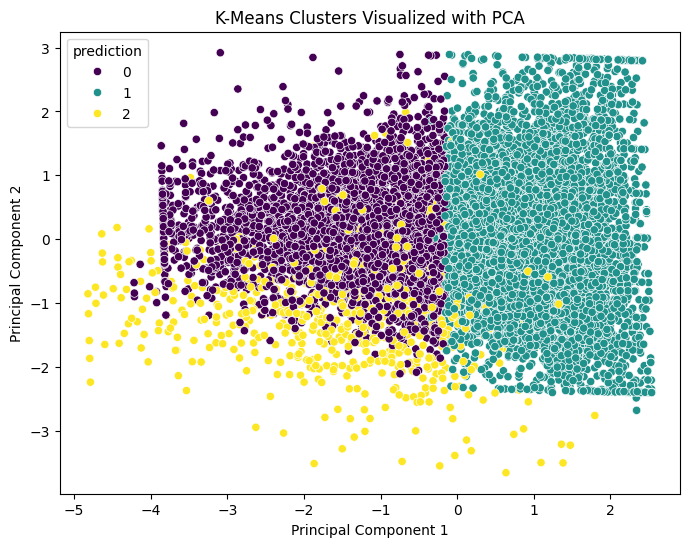

k=2, Silhouette Score=0.482
k=3, Silhouette Score=0.540
k=4, Silhouette Score=0.530
k=5, Silhouette Score=0.518
k=6, Silhouette Score=0.446
k=7, Silhouette Score=0.464
k=8, Silhouette Score=0.451
k=9, Silhouette Score=0.454


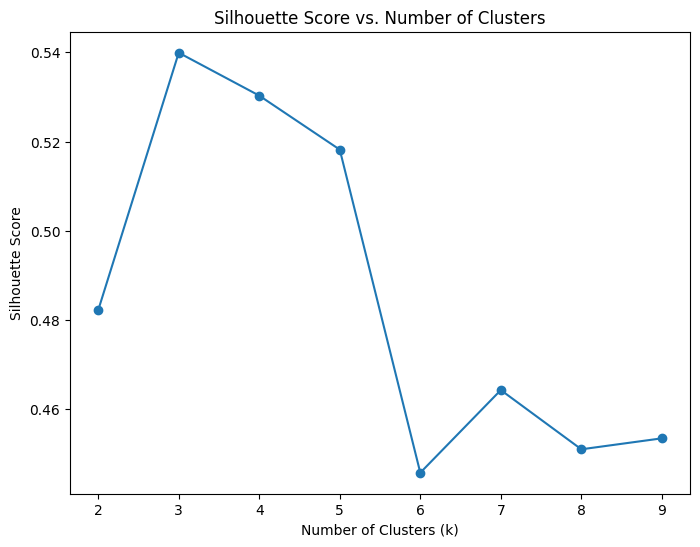

In [32]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2 principal components
pca = PCA(k=2, inputCol='features', outputCol='pcaFeatures')
pca_model = pca.fit(kmeans_predictions)
pca_result = pca_model.transform(kmeans_predictions)

# Collect data to Pandas DataFrame
pca_data = pca_result.select('pcaFeatures', 'prediction').toPandas()

# Extract PCA features
pca_data['pc1'] = pca_data['pcaFeatures'].apply(lambda x: x[0])
pca_data['pc2'] = pca_data['pcaFeatures'].apply(lambda x: x[1])


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pc1', y='pc2',
    hue='prediction',
    palette='viridis',
    data=pca_data,
    legend='full'
)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(clustering_data)
    predictions = model.transform(clustering_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"k={k}, Silhouette Score={silhouette:.3f}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()



## Customer Sales Data

In [45]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier


# Load the dataset
data = spark.read.csv("customer_sales.csv", header=True, inferSchema=True)

# Data Preparation
# Replace 'feature1', 'feature2', 'feature3' with actual column names from your dataset
assembler = VectorAssembler(inputCols=["order_item_subtotal", "order_item_quantity", "order_item_product_price"], outputCol="features")
data = assembler.transform(data)

# Create a new categorical label column based on 'order_item_subtotal'.**
# This example creates 3 categories based on quantiles: low, medium, high.
# You can adjust the logic based on your specific needs.

quantile_value = data.approxQuantile("order_item_subtotal", [0.33], 0.01)[0] # Calculate quantile on DataFrame

data = data.withColumn("sales_category", when(col("order_item_subtotal") < quantile_value, "low") \
                                        .when(col("order_item_subtotal") < data.approxQuantile("order_item_subtotal", [0.66], 0.01)[0], "medium") \
                                        .otherwise("high"))
# Use StringIndexer to convert the categorical label to numerical indices.**
indexer = StringIndexer(inputCol="sales_category", outputCol="label")
data = indexer.fit(data).transform(data)

# Update the MultilayerPerceptronClassifier with the new label column.**
neuralNetwork = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", maxIter=100, layers=[3, 5, 3])
neuralNetworkModel = neuralNetwork.fit(data)

# Unsupervised Learning: K-means Clustering
kmeans = KMeans(k=3, seed=123)
kmeansModel = kmeans.fit(data)

# Unsupervised Learning: Principal Component Analysis (PCA)
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pcaModel = pca.fit(data)
pcaResult = pcaModel.transform(data)

# Print the results
print("Neural Network Model Summary:")
print(neuralNetworkModel.summary)
print("\nK-means Clustering Model Summary:")
print(kmeansModel.summary)
print("\nPrincipal Component Analysis (PCA) Result:")
pcaResult.show()

Neural Network Model Summary:
<bound method MultilayerPerceptronClassificationModel.summary of MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_483dc8a2c729, numLayers=3, numClasses=3, numFeatures=3>

K-means Clustering Model Summary:

Principal Component Analysis (PCA) Result:
+-----------+--------------+--------------+--------------+--------+----------+---------------+-------------+---------------------+-------------------+-------------------+------------------------+--------------------+-------------+--------------------+---------------+-------------------+--------------+-----+--------------------+
|customer_id|customer_fname|customer_lname|customer_email|order_id|order_date|   order_status|order_item_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|        product_name|product_price|       category_name|department_name|           features|sales_category|label|         pcaFeatures|
+-----------+--------------+------

## Visualizations

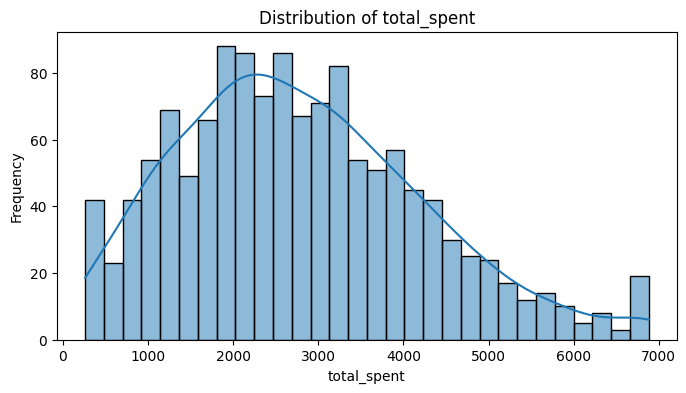

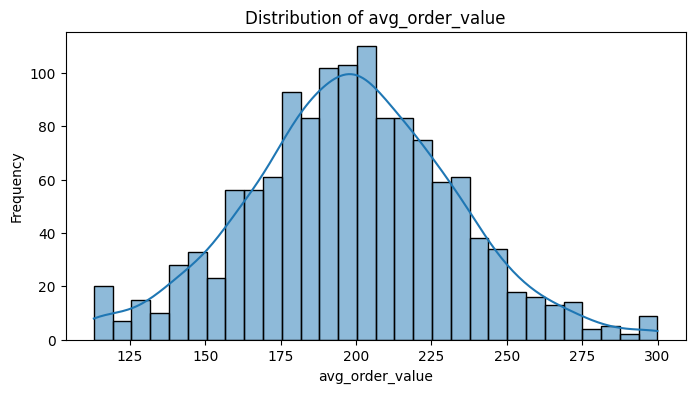

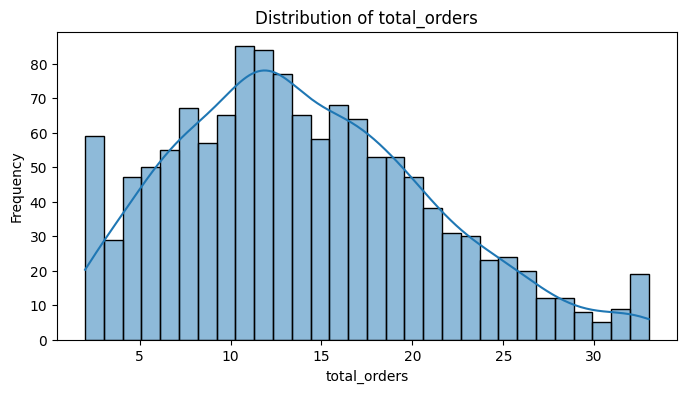

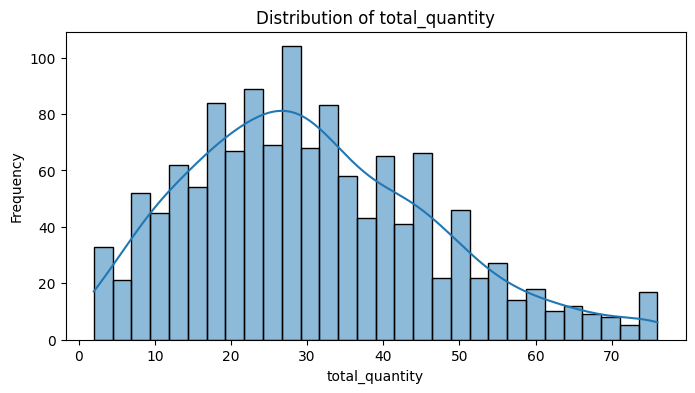

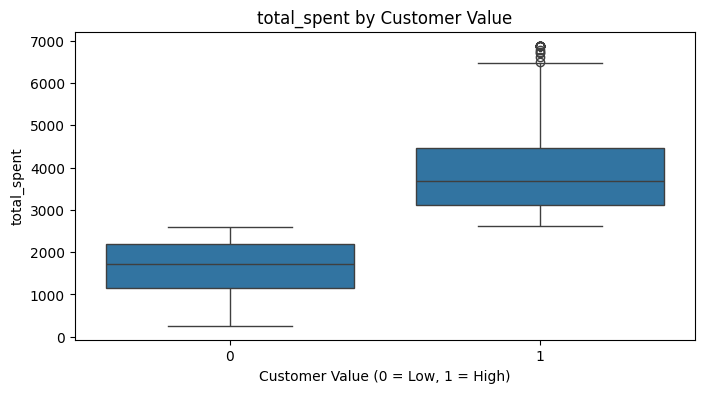

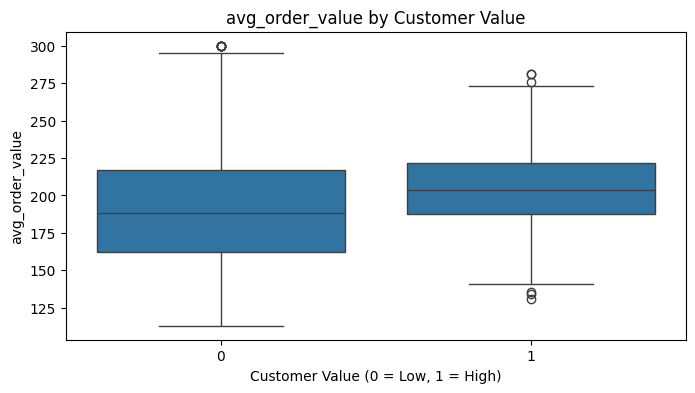

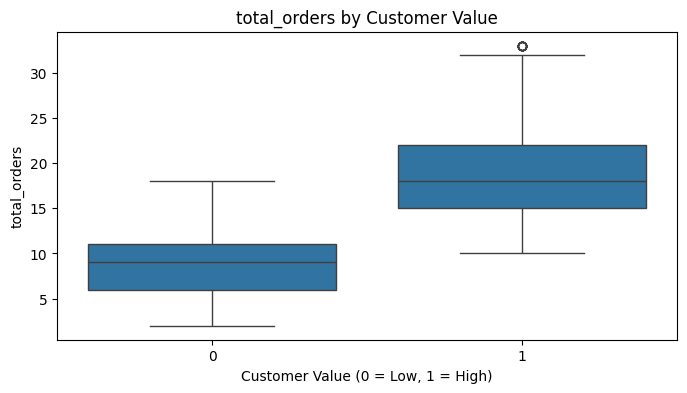

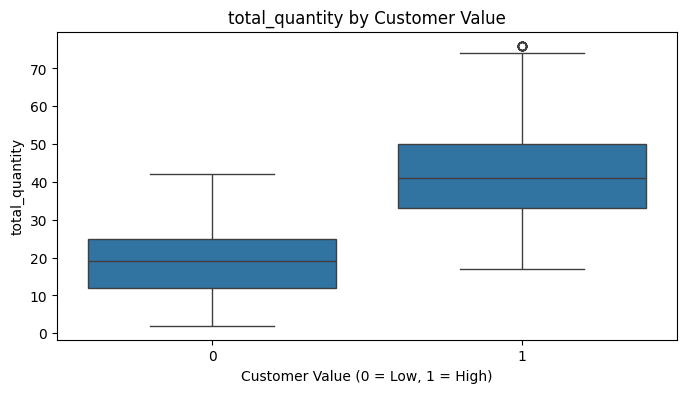

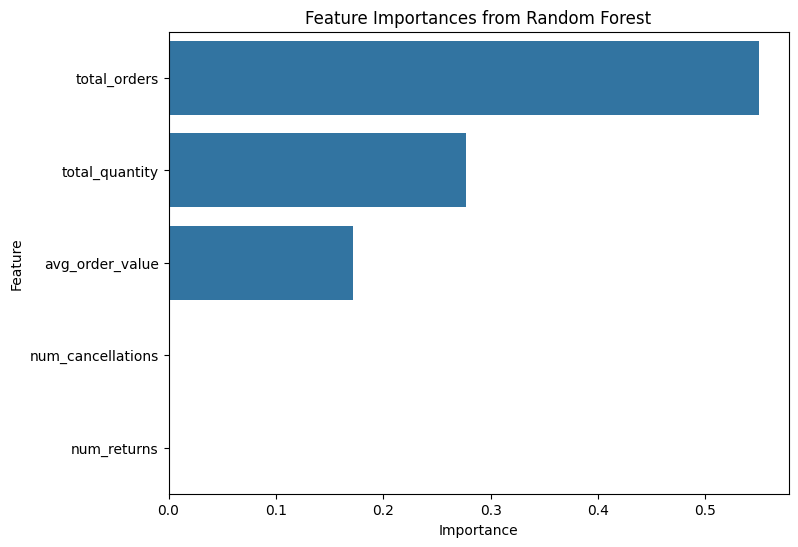

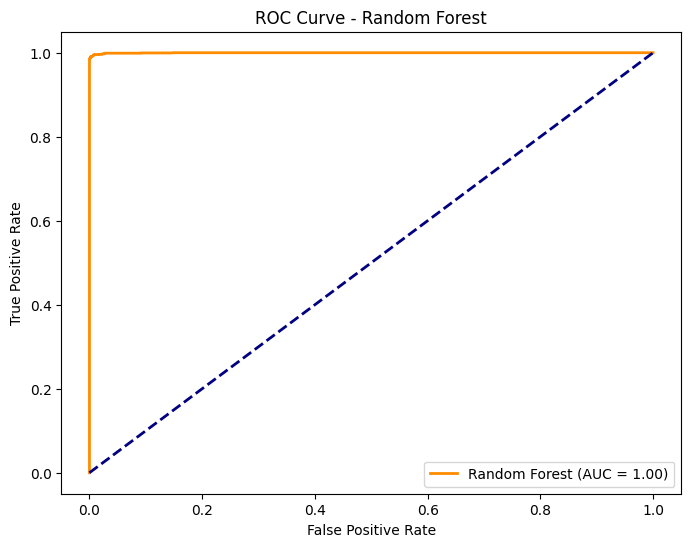

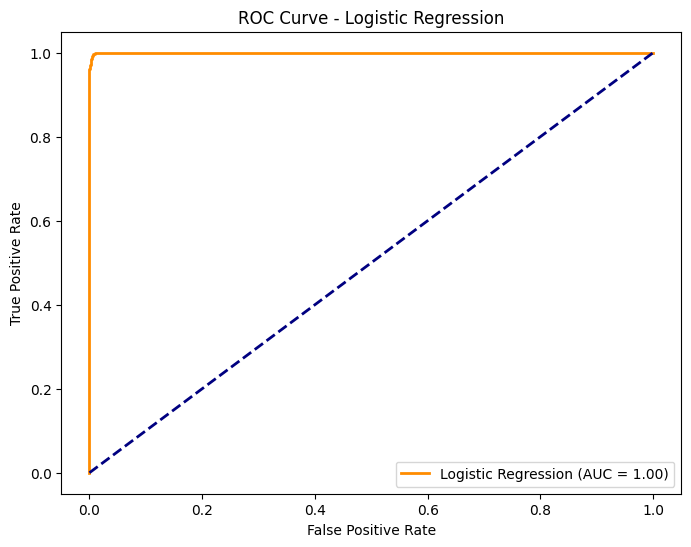

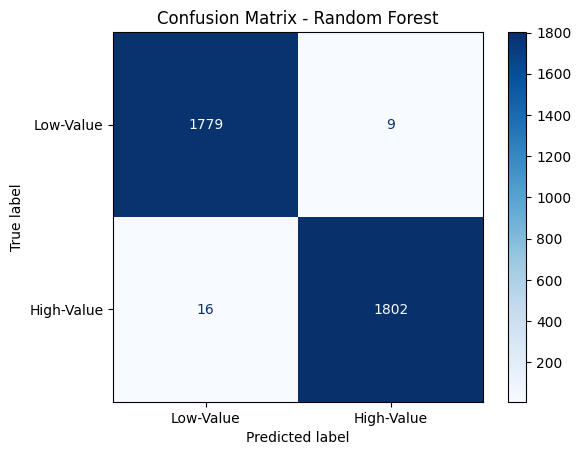

In [48]:
# Assuming previous steps have been completed and models have been trained

# 1. Data Distribution and Exploration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect a sample of the data
sample_data = customer_features_df.select(
    'total_spent', 'avg_order_value', 'total_orders', 'total_quantity',
    'num_cancellations', 'num_returns', 'label'
).sample(False, 0.1, seed=42).toPandas()
print("\n")
# Histograms
features_to_plot = ['total_spent', 'avg_order_value', 'total_orders', 'total_quantity']

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(sample_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
print("\n")
# Box Plots
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='label', y=feature, data=sample_data)
    plt.title(f'{feature} by Customer Value')
    plt.xlabel('Customer Value (0 = Low, 1 = High)')
    plt.ylabel(feature)
    plt.show()
print("\n")
# 2. Feature Importance Visualization
import pandas as pd

feature_importances = rf_model.featureImportances.toArray()
features_list = feature_columns

feature_importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
print("\n")
# 3. ROC Curve Visualization
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(predictions, model_name):
    pred_scores = predictions.select('label', 'probability').collect()
    y_true = [row['label'] for row in pred_scores]
    y_score = [row['probability'][1] for row in pred_scores]

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
print("\n")
# Plot ROC curves
rf_predictions = rf_predictions.cache()
plot_roc_curve(rf_predictions, 'Random Forest')

lr_predictions = lr_predictions.cache()
plot_roc_curve(lr_predictions, 'Logistic Regression')
print("\n")
# 4. Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(predictions, model_name):
    pred_labels = predictions.select('label', 'prediction').collect()
    y_true = [row['label'] for row in pred_labels]
    y_pred = [row['prediction'] for row in pred_labels]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low-Value', 'High-Value'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
print("\n")
# Plot confusion matrix for Random Forest
plot_confusion_matrix(rf_predictions, 'Random Forest')


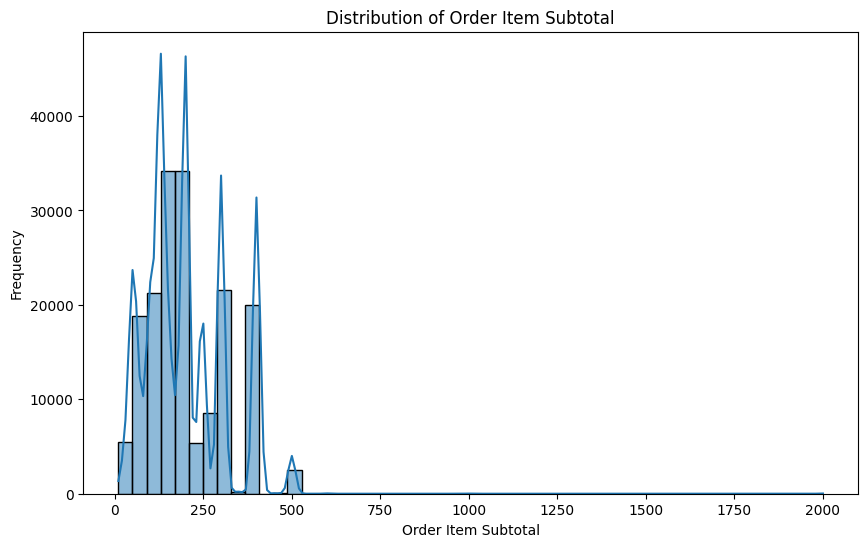

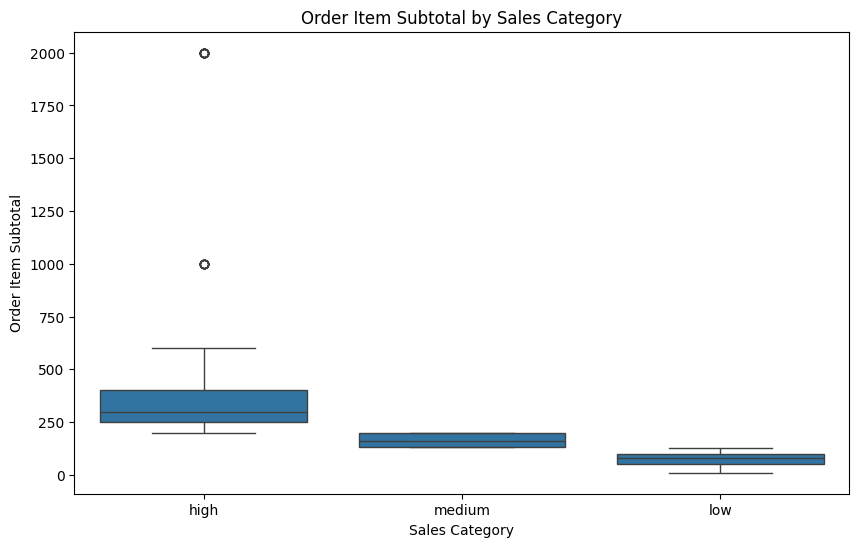

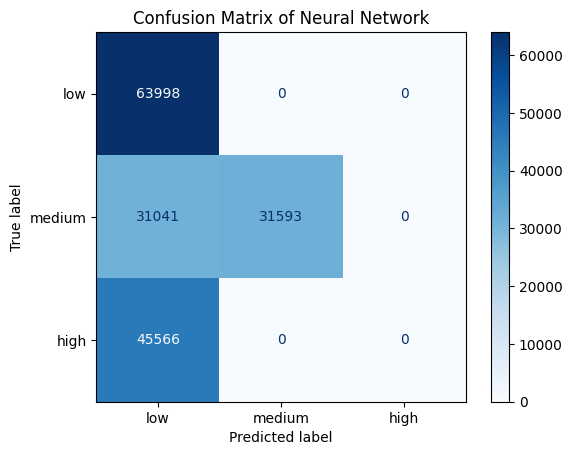



Classification Report:

              precision    recall  f1-score   support

         low       0.46      1.00      0.63     63998
      medium       1.00      0.50      0.67     62634
        high       0.00      0.00      0.00     45566

    accuracy                           0.56    172198
   macro avg       0.49      0.50      0.43    172198
weighted avg       0.53      0.56      0.48    172198





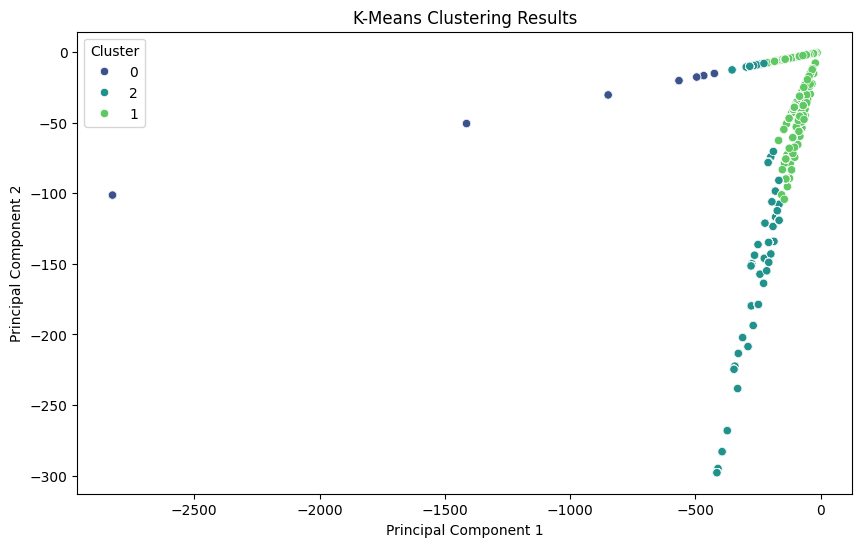

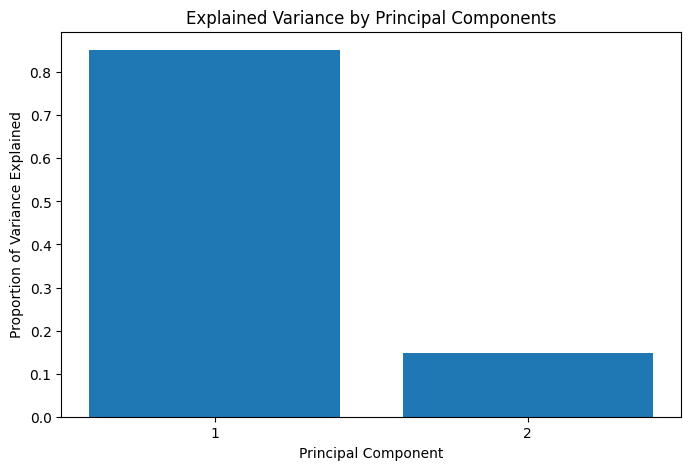

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when, col
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. Visualizing Data Distribution
data_pd = data.select("order_item_subtotal", "sales_category").toPandas()
print("\n")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data_pd['order_item_subtotal'], bins=50, kde=True)
plt.title('Distribution of Order Item Subtotal')
plt.xlabel('Order Item Subtotal')
plt.ylabel('Frequency')
plt.show()
print("\n")

# Boxplot by Sales Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='sales_category', y='order_item_subtotal', data=data_pd)
plt.title('Order Item Subtotal by Sales Category')
plt.xlabel('Sales Category')
plt.ylabel('Order Item Subtotal')
plt.show()
print("\n")

# Neural Network Performance
predictions = neuralNetworkModel.transform(data)
predictions_pd = predictions.select("label", "prediction").toPandas()
print("\n")

# Confusion Matrix
cm = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low', 'medium', 'high'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Neural Network')
plt.show()
print("\n")

# Classification Report
print("Classification Report:\n")
print(classification_report(predictions_pd['label'], predictions_pd['prediction'], target_names=['low', 'medium', 'high'], zero_division=0)) # Add zero_division=0
print("\n")

# K-Means Clustering Visualization
clustered_data = kmeansModel.transform(data)
pcaModel = pca.fit(clustered_data)
pcaResult = pcaModel.transform(clustered_data)
pca_pd = pcaResult.select("pcaFeatures", "prediction").toPandas()
pca_pd['pca1'] = pca_pd['pcaFeatures'].apply(lambda x: x[0])
pca_pd['pca2'] = pca_pd['pcaFeatures'].apply(lambda x: x[1])
pca_pd['cluster'] = pca_pd['prediction'].astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_pd, palette='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
print("\n")

# 4. PCA Explained Variance
explained_variance = pcaModel.explainedVariance.toArray()
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance)+1), explained_variance, tick_label=range(1, len(explained_variance)+1)) # Corrected the typo here
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()
